# Perturbation Space

pertpy introduces a novel conceptual framework that distinctly delineates between two fundamental domains: the "cell space" and the "perturbation space."
In this paradigm, the cell space encapsulates configurations where discrete data points inherently represent individual cells.
A prevalent manifestation of this pattern can be observed through prominent visualization techniques such as UMAP embeddings as commonly observed in publications.
Conversely, the perturbation space departs from the individualistic perspective of cells and instead organizes cells into cohesive ensembles that have undergone similar perturbations. These grouped cells are subsequently embedded to faithfully encapsulate the nature of the perturbation itself.
This specialized space enables comprehending the collective impact of perturbations on cells.

pertpy offers [several distinct ways](https://pertpy.readthedocs.io/en/latest/usage/usage.html#perturbation-space) of determining the perturbation space that we will introduce in the following.

We will be working with the pre-processed Norman dataset, which encompases a pooled CRISPR screening experiment comparing the transcriptional effects of overexpressing genes alone or in combination.

Reference: Norman, Thomas M et al. “Exploring genetic interaction manifolds constructed from rich single-cell phenotypes.” Science (New York, N.Y.) vol. 365,6455 (2019): 786-793. doi:10.1126/science.aax4438

## Setup

In [23]:
import sys
sys.path.append('/Users/mamba/Documents')
import Code.pertpy.pertpy as pt

In [24]:
import pertpy as pt
import scanpy as sc

In [25]:
adata = pt.dt.norman_2019()
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [26]:
adata.obs

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,4108,4108,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,3142,3142,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,4229,4229,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,2114,2114,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,2753,2753,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGTACGT-8,FOXA3_NegCtrl0__FOXA3_NegCtrl0,2068,95,21.768421,8,True,1,0,0,0,...,3305,3305,14727.0,898.0,6.097644,3,FOXA3,genetic,NaN,NaN
TTTGTCATCCACTCCA-8,CELF2_NegCtrl0__CELF2_NegCtrl0,829,33,25.121212,8,True,1,0,0,0,...,2842,2842,9750.0,566.0,5.805128,10,CELF2,genetic,NaN,NaN
TTTGTCATCCCAACGG-8,BCORL1_NegCtrl0__BCORL1_NegCtrl0,136,9,15.111111,8,True,1,0,0,0,...,2824,2824,8670.0,490.0,5.651672,4,BCORL1,genetic,NaN,NaN


In [27]:
G1_CYCLE = [
    'CDKN1A', {'CDKN1B', 'CDKN1A'}, 'CDKN1B', {'CDKN1C', 'CDKN1A'}, {'CDKN1C', 'CDKN1B'}, 'CDKN1C'
]

ERYTHROID = [
    {'CBL', 'CNN1'}, {'CBL', 'PTPN12'}, {'CBL', 'PTPN9'}, {'CBL', 'UBASH3B'}, {'SAMD1', 'PTPN12'},
    {'SAMD1', 'UBASH3B'}, {'UBASH3B', 'CNN1'}, {'UBASH3B', 'PTPN12'}, {'UBASH3B', 'PTPN9'}, {'UBASH3B', 'UBASH3A'},
    {'UBASH3B', 'ZBTB25'}, {'BPGM', 'SAMD1'}, 'PTPN1', {'PTPN12', 'PTPN9'}, {'PTPN12', 'UBASH3A'}, {'PTPN12', 'ZBTB25'}, {'UBASH3A', 'CNN1'}
]

PIONEER_FACTORS = [
    {'FOXA1', 'FOXF1'}, {'FOXA1', 'FOXL2'}, {'FOXA1', 'HOXB9'}, {'FOXA3', 'FOXA1'}, {'FOXA3', 'FOXF1'}, {'FOXA3', 'FOXL2'}, {'FOXA3', 'HOXB9'}, 'FOXA3', {'FOXF1', 'FOXL2'}, {'FOXF1', 'HOXB9'}, {'FOXL2', 'MEIS1'}, 'HOXA13',
    'HOXC13', {'POU3F2', 'FOXL2'}, 'TP73', 'MIDN', {'LYL1', 'IER5L'}, 'HOXC13', {'DUSP9', 'SNAI1'}, {'ZBTB10', 'SNAI1'}
]

GRANULOCYTE_APOPTOSIS = [
    'SPI1', 'CEBPA', {'CEBPB', 'CEBPA'}, 'CEBPB', {'CEBPE', 'CEBPA'}, {'CEBPE', 'CEBPB'}, {'CEBPE', 'RUNX1T1'},
    {'CEBPE', 'SPI1'}, 'CEBPE', {'ETS2', 'CEBPE'}, {'KLF1', 'CEBPA'}, {'FOSB', 'CEBPB'}, {'FOSB', 'CEBPE'},{'ZC3HAV1', 'CEBPA'}, {'JUN', 'CEBPA'}
]

PRO_GROWTH = [
    {'CEBPE', 'KLF1'}, 'KLF1', {'KLF1', 'BAK1'}, {'KLF1', 'MAP2K6'}, {'KLF1', 'TGFBR2'}, 'ELMSAN1', {'MAP2K3', 'SLC38A2'}, {'MAP2K3', 'ELMSAN1'}, 'MAP2K3', {'MAP2K3', 'MAP2K6'}, {'MAP2K6', 'ELMSAN1'}, 'MAP2K6', {'MAP2K6', 'KLF1'}
]

MEGAKARYOCYTE = [
    {'MAPK1', 'TGFBR2'}, 'MAPK1', {'ETS2', 'MAPK1'}, 'ETS2', {'CEBPB', 'MAPK1'}
]

programmes = {
    'G1 cell cycle': G1_CYCLE,
    'Erythroid': ERYTHROID,
    'Pioneer factors': PIONEER_FACTORS,
    'Granulocyte apoptosis': GRANULOCYTE_APOPTOSIS,
    'Pro-growth': PRO_GROWTH,
    'Megakaryocyte': MEGAKARYOCYTE
}

In [28]:
gene_programme = []

for target_pert in adata.obs['perturbation_name']:
    if target_pert=='control':
        gene_programme.append('Control')
        continue
        
    determined = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split('+'))) or (target_pert == pert):
                    gene_programme.append(programme)
                    determined = True
                    break
    if not determined:
        gene_programme.append('Unknown')

adata.obs['gene_programme'] = gene_programme

In [29]:
adata = adata[adata.obs['gene_programme'] != 'Unknown']

## Embed data in Perturbation Spaces
### Pseudobulk Space

The Pseudobulk space returns an Anndata in which each observation corresponds to the pseudobulk expression of all cells with a given perturbation.

In [8]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(adata, target_col="perturbation_name", groups_col="perturbation_name", mode="mean", min_cells=0, min_counts=0)

In [9]:
psadata

AnnData object with n_obs × n_vars = 75 × 19017
    obs: 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'guide_KLF1', 'guide_KMT2A', 'guide_LHX1', 'guide_LYL1', 'guide_MAML2', 'guide_MAP2K3', 'guide_MAP2K6', 'guide

In [10]:
psadata.obs.head()

,guide_AHR,guide_ARID1A,guide_ARRDC3,guide_ATL1,guide_BAK1,guide_BCL2L11,guide_BCORL1,guide_BPGM,guide_C19orf26,guide_C3orf72,...,guide_ZC3HAV1,guide_ZNF318,guide_ids,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_programme,psbulk_n_cells,psbulk_counts
BAK1+KLF1,0,0,0,0,1,0,0,0,0,0,...,0,0,"BAK1,KLF1",BAK1+KLF1,genetic,NaN,NaN,Pro-growth,392.0,1.186428e+06
BPGM+SAMD1,0,0,0,0,0,0,0,1,0,0,...,0,0,"BPGM,SAMD1",BPGM+SAMD1,genetic,NaN,NaN,Erythroid,300.0,8.491724e+05
CBL+CNN1,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,CNN1",CBL+CNN1,genetic,NaN,NaN,Erythroid,348.0,9.622422e+05
CBL+PTPN12,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,PTPN12",CBL+PTPN12,genetic,NaN,NaN,Erythroid,333.0,9.529553e+05
CBL+PTPN9,0,0,0,0,0,0,0,0,0,0,...,0,0,"CBL,PTPN9",CBL+PTPN9,genetic,NaN,NaN,Erythroid,305.0,8.501961e+05


In the generated Anndata, each observation is a perturbation and its expression is the `mode` of the PseudobulkSpace function.

Now the perturbation space can be visualised, query and be subject of different operations.

In [42]:
psadata.obs.perturbation_name = psadata.obs.perturbation_name.astype('category')

         Falling back to preprocessing with `sc.pp.pca` and default params.


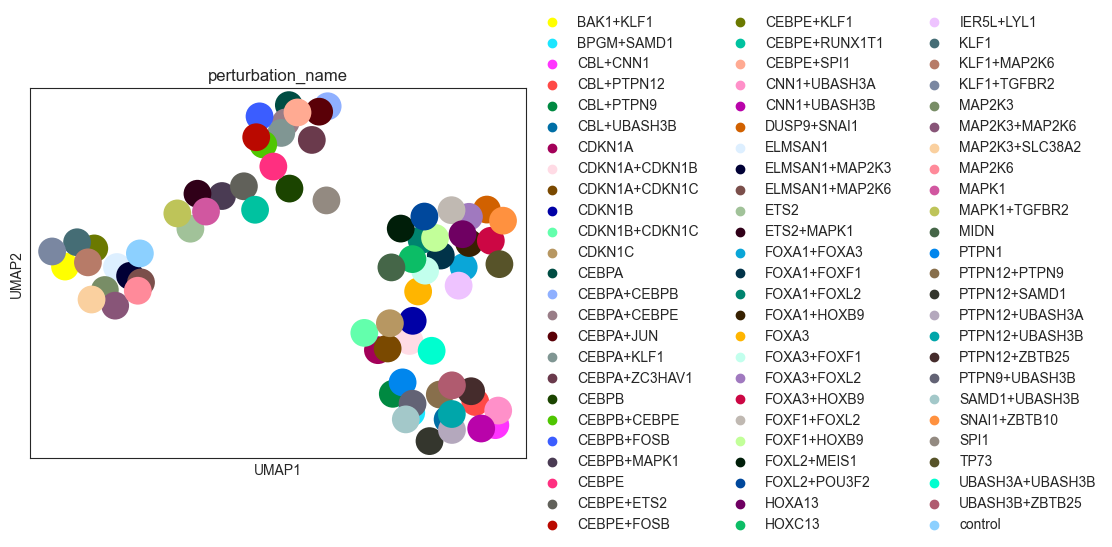

In [43]:
sc.pp.neighbors(psadata)
sc.tl.umap(psadata)
sc.pl.umap(psadata, color='perturbation_name')

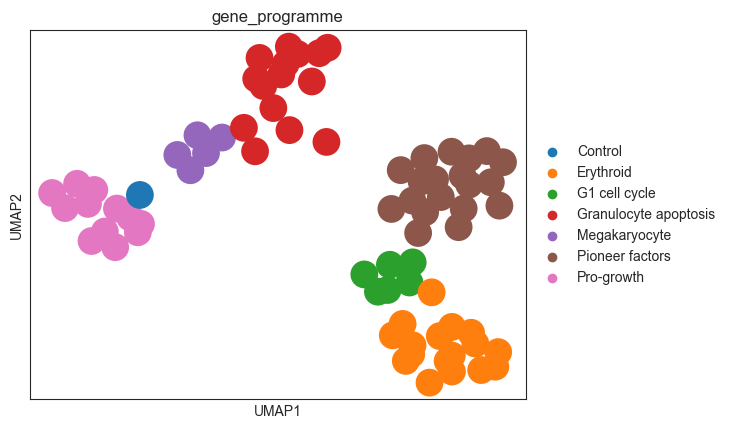

In [44]:
sc.pl.umap(psadata, color='gene_programme')

#TODO: Change interpretation

From the visualization of the perturbational space, one can see that there exist three clear groups of perturbations. 
The first group seems to have subtle effects since they are clustered together with `NT`, which is the `no-targeting` guide.
The second group clusters perturbations such as `STAT1`, `JAK2` or `IFNGR1`.
Finally, the third group is uniquely constituted by `SMAD4`. The perturbational effect of each group is different.

In [ ]:
diff_adata = ps.compute_control_diff(adata, target_col='perturbation_name', reference_key='control')

### Discriminator Classifier

The Discriminator Classifier embedding method trains a NN classifier to predict which perturbation has been applied to each cell. Once the training has finished, if get the representations of the last layer as embedding of the perturbations.

In [46]:
ps = pt.tl.DiscriminatorClassifierSpace()

The `load` method creates the model to train and the dataloaders. It accepts different hyperparameters related with the architecture of the model such as `hidden_dim`, `dropout`, `batch_norm`, etc. 
Training hyperparameters such as `batch_size`, `test_split_size`, `validation_split_size` can also be changed.

In [57]:
classifier_ps = ps.load(adata, target_col="perturbation_name", hidden_dim=[512, 256], dropout=0.05)

Let's train just for a few epochs. The trainer uses GPU if available.

In [ ]:
classifier_ps.train(max_epochs=20)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | net  | MLP  | 9.9 M 
------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.559    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


Training: 0it [00:00, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


Validation: 0it [00:00, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R 
support.


In [ ]:
pert_embeddings = classifier_ps.get_embeddings()

The embeddings are extracted from the last layer (256, as previously set), and are the representation of each cell. Therefore, PseudobulkSpace or any other transformation can be applied to further investigate the space.

In [48]:
pert_embeddings.obs

,perturbations
0,STAT2
1,CAV1
2,STAT1
3,CD86
4,IRF7
...,...
244,CMTM6
245,NT
246,ATF2
247,CAV1


In [49]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(pert_embeddings,  mode="mean", min_cells=0, min_counts=0)

In [50]:
psadata.obs.head()

,perturbations,psbulk_n_cells,psbulk_counts
ATF2,ATF2,1102.0,99193.234375
BRD4,BRD4,341.0,29708.853516
CAV1,CAV1,882.0,78942.617188
CD86,CD86,1197.0,105509.265625
CMTM6,CMTM6,817.0,72084.515625


In [51]:
psadata.obs.perturbations = psadata.obs.perturbations.astype('category')

In [52]:
sc.tl.pca(psadata)

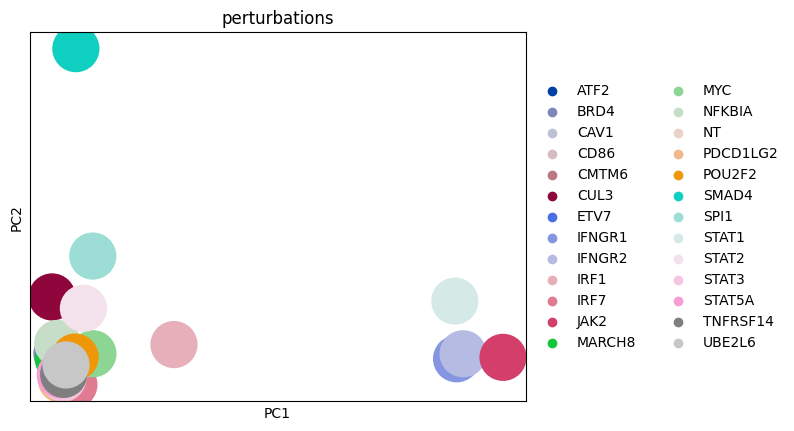

In [53]:
sc.pl.pca(psadata, color='perturbations')

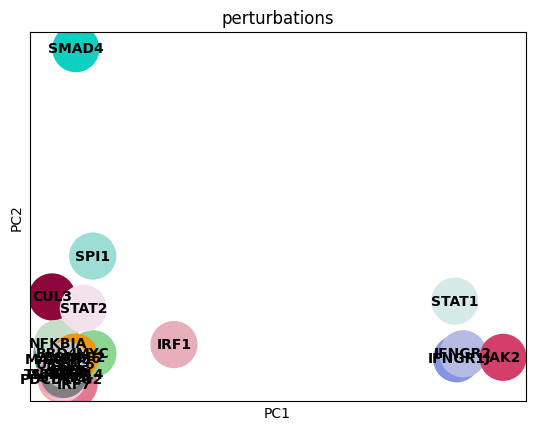

In [54]:
sc.pl.pca(psadata, color='perturbations', legend_loc='on data')

As it can be seen with the PCA of the generated space, the results are quite similar, there still exists three clear groups of perturbations according to their effects.

### Centroid Space

The Centroid Space computes the centroids per perturbation of a pre-computed embedding. So we first need to compute an embedding in the original dataset.
Note that in this particular dataset, the UMAP is already computed. Nevertheless, we will compute it again to show how to use the Centroid Space.

In [7]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

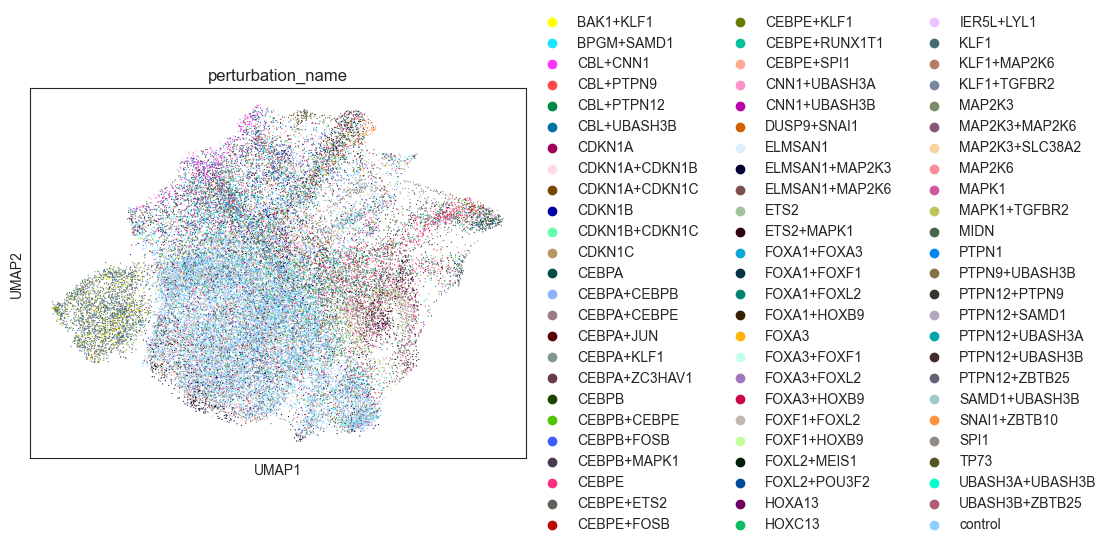

In [8]:
sc.pl.umap(adata, color="perturbation_name")

In [18]:
ps = pt.tl.CentroidSpace()
psadata = ps.compute(adata, target_col="perturbation_name", embedding_key="X_umap", keep_obs='gene_programme')

In [19]:
psadata

AnnData object with n_obs × n_vars = 75 × 2
    obs: 'perturbation_name', 'gene_programme'
    obsm: 'X_umap'

In [20]:
psadata.obs.perturbation_name = psadata.obs.perturbation_name.astype('category')

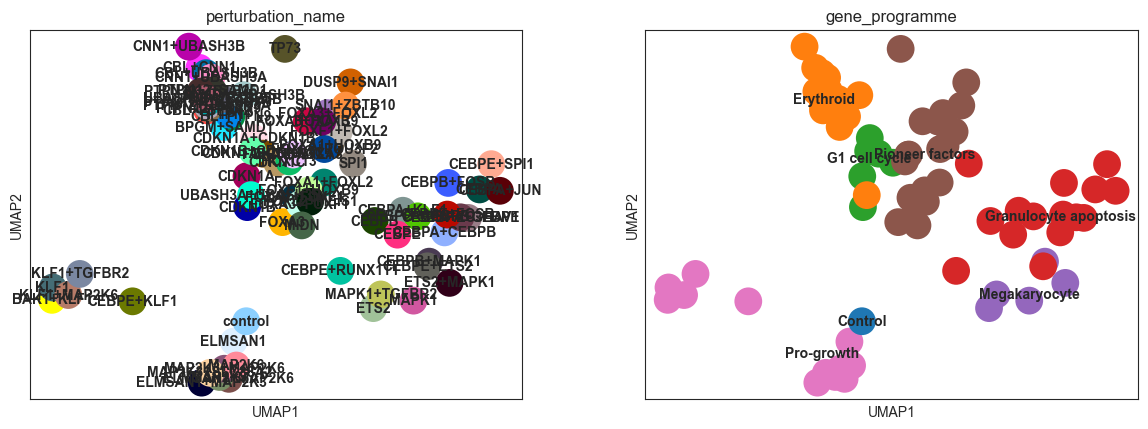

In [22]:
sc.pl.umap(psadata, color=["perturbation_name", "gene_programme"], legend_loc='on data')

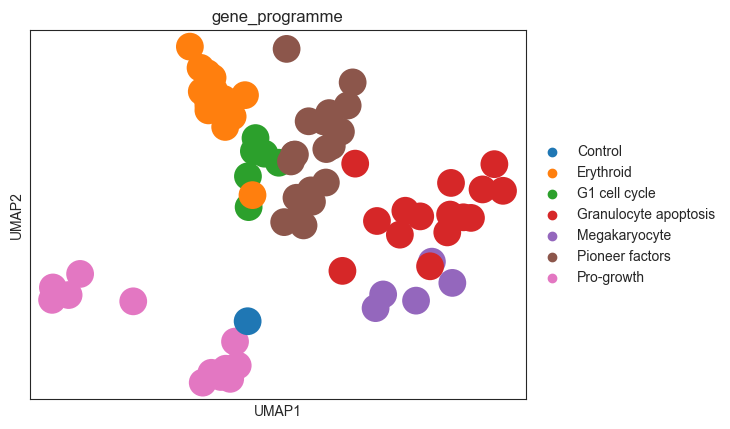

In [14]:
sc.pl.umap(psadata, color="gene_programme")

In [20]:
import pandas as pd

obs_to_keep = 'gene_programme'
#psadata.obs[obs_to_keep] = None

unique_perts = psadata.obs.perturbation_name.unique()

# Create a dictionary mapping perturbation names to the corresponding observation value
pert_values = {pert: adata[adata.obs.perturbation_name == pert].obs[obs_to_keep].unique()[0] for pert in unique_perts}

# Assign observation values to psadata
psadata.obs[obs_to_keep] = psadata.obs.perturbation_name.map(pert_values)

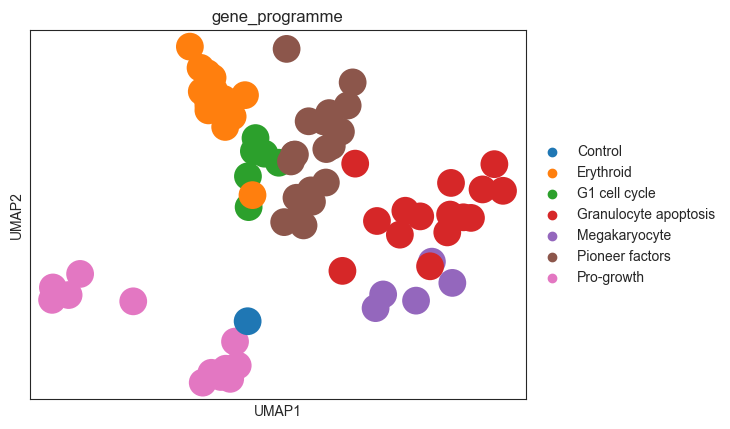

In [21]:
sc.pl.umap(psadata, color="gene_programme")

In [29]:
obs_to_keep = ['gene_programme', 'B', 'C']
psadata.obs[obs_to_keep[0]] = None
dict = {}

for obs_name in obs_to_keep:
    for pert in psadata.obs.perturbation_name.unique():
        temp_adata = adata[adata.obs.perturbation_name == pert]
        if temp_adata.obs[obs_to_keep[0]].unique().shape[0] != 1:
            raise ValueError("There are more than one value for the observation to keep")
        dict[pert] = temp_adata.obs[obs_to_keep[0]].unique()[0]
    
    psadata.obs[obs_to_keep[0]] = [dict[pert] for pert in psadata.obs_names]

In [28]:
for obs_name in ['gene_programme']:
    for pert in psadata.obs.perturbation_name.unique():
        obs_value = adata[adata.obs.perturbation_name == pert].obs[obs_name].unique()
        if len(obs_value) > 1:
            raise ValueError(f"Obs {obs_name!r} has more than one value for perturbation {pert!r}. "
                             f"You can only keep obs columns with an unambiguous value for each perturbation.")
        psadata.obs.loc[psadata.obs.index == pert, obs_name] = obs_value[0]

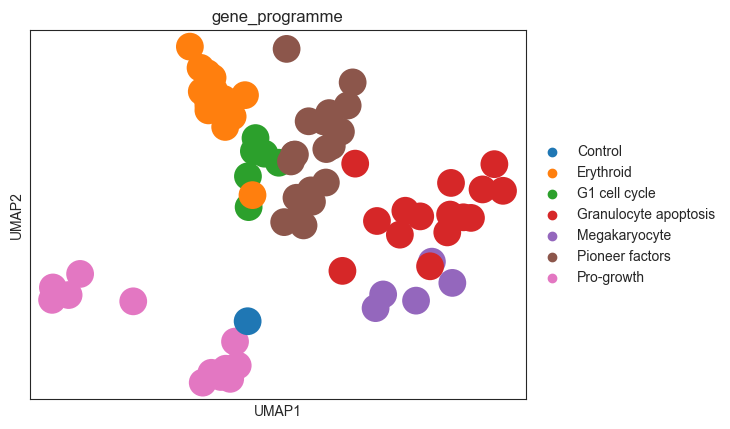

In [29]:
sc.pl.umap(psadata, color="gene_programme")

In this plot it can been identified again three clusters. Those are the same three clusters that appear in all the other generated Perturbational Spaces: A main one with most of the perturbations around `NT`. A small one with just `SMAD4`. `JAK2`, `STAT1`, `IFNGR2` and `IFNGR1`.

## Cluster Spaces
### DBScan Space

It clusters the given data using DBSCAN. It admits any option from the original sklearn DBSCAN function.

In [31]:
#adata = sc.pp.subsample(adata, 0.1, copy=True)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [54]:
adata

AnnData object with n_obs × n_vars = 40763 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [61]:
# ToDo: Try "X_pca" as embedding_key
ps = pt.tl.DBSCANSpace()
dbscan_psadata = ps.compute(adata, min_samples=50, eps=0.3, copy=True, embedding_key="X_umap")

In [62]:
dbscan_psadata

AnnData object with n_obs × n_vars = 40763 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

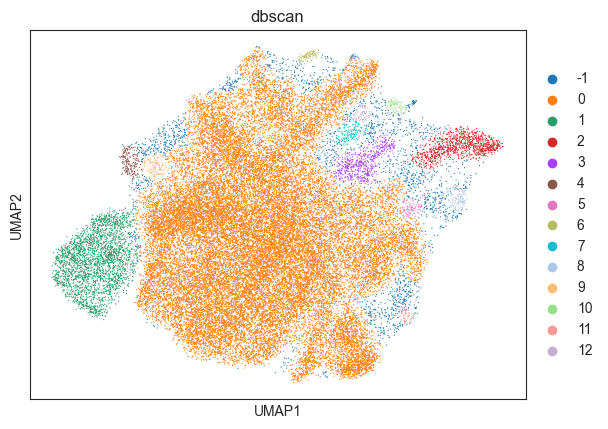

In [63]:
dbscan_psadata.obs.dbscan = dbscan_psadata.obs.dbscan.astype('category')
sc.pl.umap(dbscan_psadata, color="dbscan")

In [ ]:
results = ps.evaluate_clustering(psadata, true_label_col="perturbations", cluster_col="k-means", metric="l1")

plot interpretation

### K-Means Space

It clusters the given data using DBSCAN. It admits any option from the original sklearn DBSCAN function.

In [ ]:
ps = pt.tl.KMeansSpace()
psadata = ps.compute(adata, n_clusters=26, copy=True)

In [ ]:
psadata

In [11]:
results = ps.evaluate_clustering(adata, true_label_col="gene_target", cluster_col="k-means", metric="l2")

In [14]:
results

{'nmi': 0.08460674293686779, 'ari': 0.025376124943725657, 'asw': -0.07754745}

In [12]:
sc.tl.pca(adata)

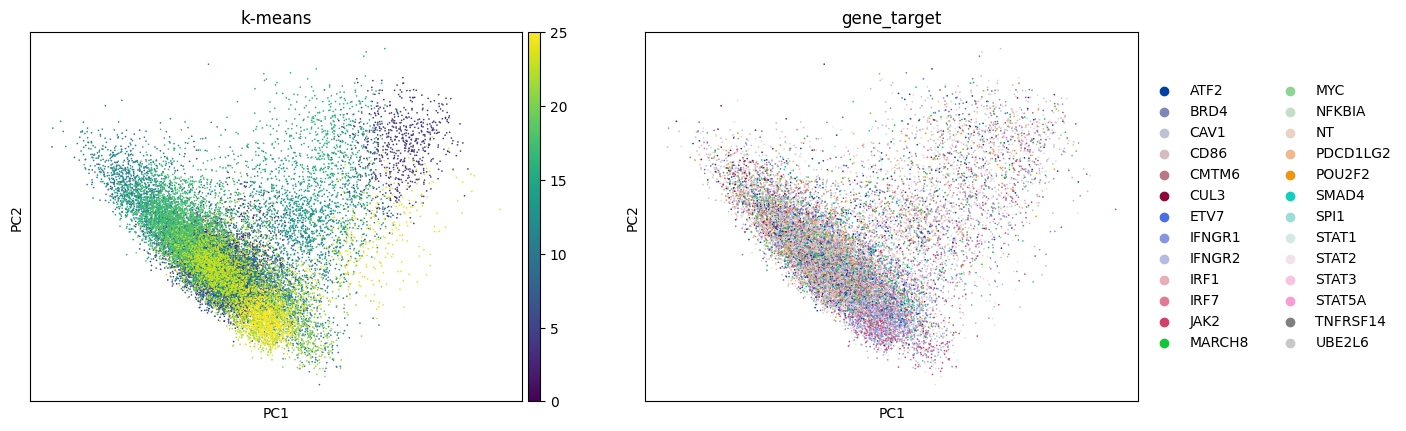

In [13]:
sc.pl.pca(adata, color=['k-means', 'gene_target'])

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

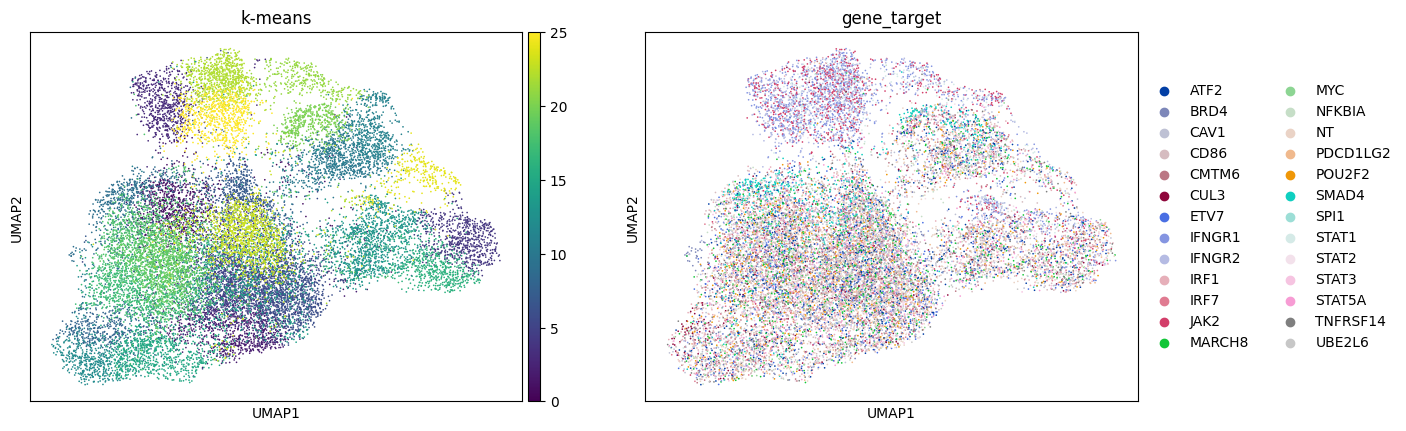

In [16]:
sc.pl.umap(adata, color=['k-means', 'gene_target'])

plot interpretation

## Evaluate Perturbation Spaces

## Perturbation arithmetics

In [ ]:
ps = pt.tl.PseudobulkSpace()
psadata = ps.compute(adata, target_col="perturbation_name", groups_col="perturbation_name", mode="mean", min_cells=0, min_counts=0)

new_perturbation = ps.add(psadata, perturbations=["ETS2", "MAPK1"], reference_key='control')

## Conclusion

bla.